In [1]:
# Install required packages
%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Note: you may need to restart the kernel to use updated packages.



C:\Users\wammi\AppData\Local\Temp\ipykernel_33428\3925349407.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


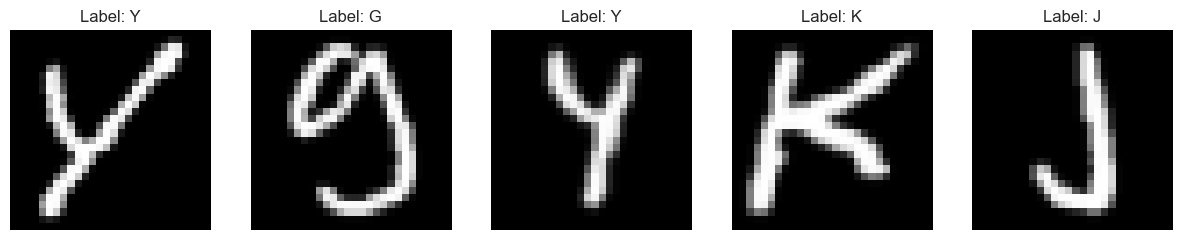

In [2]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

# Load EMNIST Letters dataset as supervised pairs (image, label)
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

# Convert tf.data.Dataset to NumPy arrays
def convert_to_numpy(ds):
    x = []
    y = []
    for image, label in tfds.as_numpy(ds):
        x.append(image)
        y.append(label)
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = convert_to_numpy(ds_train)
x_test, y_test = convert_to_numpy(ds_test)

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(x_train[i].squeeze()), cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [3]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


In [9]:
from keras import layers

# Create CNN using Keras
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # adjustable
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and compile model
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 11, 11, 64)       

Epoch 1/20



2220/2220 [==============================] - 27s 11ms/step - loss: 0.8250 - accuracy: 0.7488 - val_loss: 0.3146 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 2/20
2220/2220 [==============================] - 30s 13ms/step - loss: 0.4553 - accuracy: 0.8538 - val_loss: 0.2498 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 3/20
2220/2220 [==============================] - 31s 14ms/step - loss: 0.3872 - accuracy: 0.8761 - val_loss: 0.2293 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 4/20
2220/2220 [==============================] - 31s 14ms/step - loss: 0.3502 - accuracy: 0.8864 - val_loss: 0.2198 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 5/20
2220/2220 [==============================] - 32s 15ms/step - loss: 0.3234 - accuracy: 0.8953 - val_loss: 0.2264 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 6/20
2220/2220 [==============================] - 32s 15ms/step - loss: 0.3066 - accuracy: 0.8998 - val_loss: 0.1946 - val_accuracy: 0.9334 - lr: 0.0010
Epoch 7/20
2220/2220 [==============================] - 3

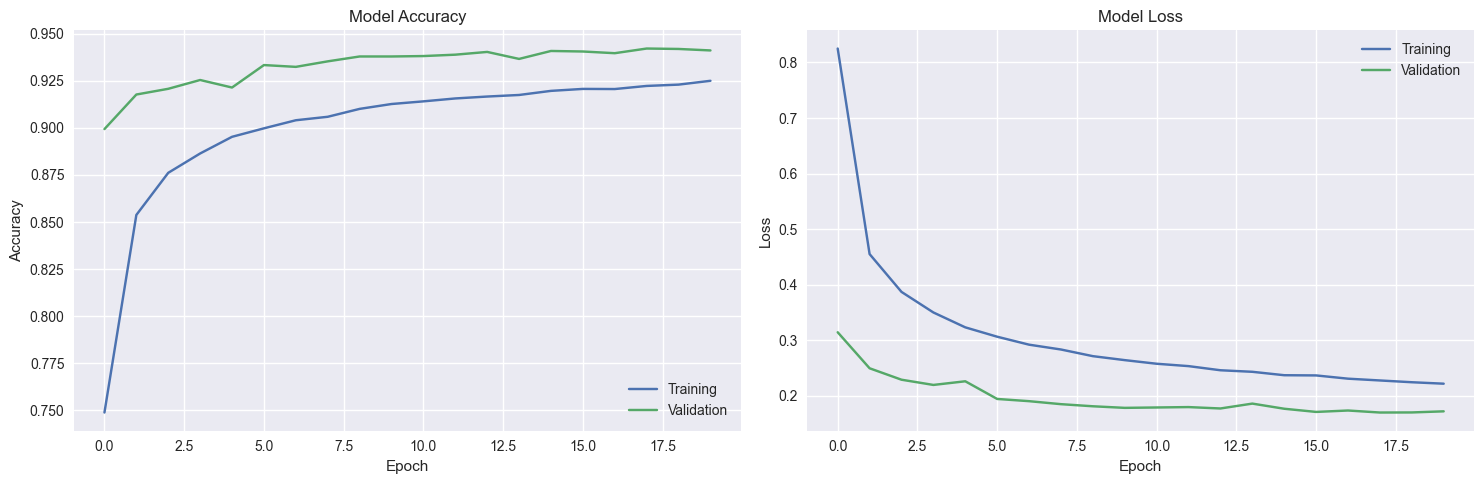

In [10]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

463/463 [==============================] - 2s 5ms/step - loss: 0.2129 - accuracy: 0.9259
Test accuracy: 0.9259
463/463 [==============================] - 3s 6ms/step


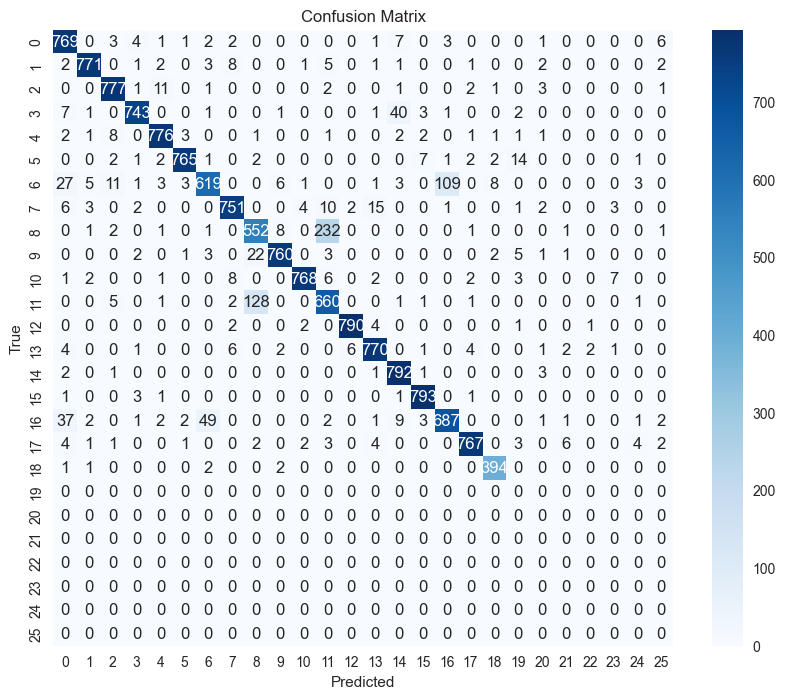

C:\Users\wammi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_2/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")